In [179]:
import numpy as np
from scipy.stats import f_oneway, ttest_ind, shapiro, probplot, levene, bartlett
import matplotlib.colors as clrs
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import patsy
import researchpy as rp

from pathlib import Path
#设置数据文件夹路径
DATA = Path().resolve()  / 'data'

# 设置浮点数打印精度
%precision 3
# 在 Jupyter Notebook 里显示图形
%matplotlib inline

# 实验设计和方差分析简介

实验：Chemitech公司开发了一种新的城市供水过滤系统。新过滤系统的部件需要从几家供应商处购买，然后由Chemitech公司设在南加州哥伦比亚市的工厂配置这些部件。

考虑了各种可能的装配方法后，工程部将范围缩小至A B C三种方法。

公司希望确定：哪种装配方法能使每周生产的过滤系统的数量最多

- 因子：引起关注的自变量的另一个称谓
- 处理：因子的不同水平
- 单因子实验：只涉及有K个总体或处理的一个因子的实验
- 响应变量：引起关注的应变量的另一个称谓
- 实验单元：实验中引起关注的研究对象
- 完全随机化试验：处理被随机地指派给实验单元的一种实验设计

在上述实验中：
- 装配方法是独立变量（因子）
- 对应因子的三种装配方法是说这一实验有三个处理
- 因此该公司的问题是单因子实验：只涉及一个定性因子（装配方法）
- 三个处理确定了实验的三个总体：使用A方法的全体工人 B方法的全体工人 C方法的全体工人
- 对于每个总体，响应变量是：每周装配的过滤系统的数量
- 假设公司随机抽取了三名工人随机的指派实行一种装配方法
- 实验单元就是三名随机抽取的工人  有三个实验单元 随机指派处理给实验单元就是完全随机化设计
- 抽15个实验单元——>每种独立变量处理随机的指派给5个实验单位——>三个总体 $n_1=5$ $n_2=5$ $n_3=5$

统计研究分为实验性研究与观测性研究
- 实验性研究中：数据是通过实验产生的
    1. 首先要确定我们感兴趣的变量开始
    2. 然后确定并控制一个或多个其他变量,这些其他变量与我们感兴趣的变量是相关的
    3. 与此同时，收集这些变量是如何影响我们感兴趣的那一个变量的数据
- 观测性研究中：数据是通过抽样调查产生的，而不是控制一项实验来获取数据的

本章主要介绍三种类型的实验设计：完全随机化设计、随机化区组设计、析因实验

对于每一种实验设计，我们将说明，方差分析（ANOVA）的统计方法如何能用于现有数据的分析 同样也可使用ANOVA来分析通过观察性研究得到的数据

- 在第1部分，将介绍实验性研究的基本原理，并且将说明如何将这些基本原理应用到完全随机化的设计中
- 第2部分中，将说明如何应用 ANOVA 来分析完全随机化实验设计的数据
- 之后的几个部分， 讨论多重比较方法和另外两个有广泛应用的实验设计：随机化区组设计和析因实验

In [47]:
# 处理一下数据，后续有用
chemitech = pd.read_csv(DATA/'Chemitech.csv')
chemitech['index'] = chemitech.index
chemitech = pd.melt(chemitech, id_vars=['index'], value_vars=list(chemitech.columns))
chemitech[['temp','Method']] = chemitech.variable.str.split(pat=' ',expand=True)
chemitechcleaned = chemitech.drop(['index', 'variable', 'temp'], axis=1)
chemitechcleaned.head()

,value,Method
0,58,A
1,64,A
2,55,A
3,66,A
4,67,A


In [48]:
chemitech = pd.read_csv(DATA/'Chemitech.csv')
chemitech

,Method A,Method B,Method C
0,58,58,48
1,64,69,57
2,55,71,59
3,66,64,47
4,67,68,49


In [49]:
chemitech.std()

Method A    5.244044
Method B    5.147815
Method C    5.567764
dtype: float64

# [单因素方差分析](https://www.pythonfordatascience.org/anova-python/)

### 先来复习一下

学习回归之前，我觉得我们有必要再复习一下上一部分学过的推断统计方法：

- 单样本 t 检验：一个定量因变量作为因变量
- 独立样本 t 检验：一个二值定类变量，一个定量变量作为因变量
- 配对样本 t 检验：一个二值定类变量，一个定量变量作为因变量，且定量变量需要配对（如使用药品前/使用药品后）
- 单因子方差分析：一个定类变量，一个定量变量作为因变量
- 双因子方差分析：两个定类变量，一个定量变量作为因变量
- 多因子方差分析：两个定类变量，一个或以上定量变量，其中一个定量变量作为因变量
    - 一般我们会把除了因变量之外的定量变量进行装箱处理，将定量变量转换为定性变量
- 复测方差分析：一个定类变量，一个或以上定量变量，其中一个定量变量作为因变量
- 协方差分析：一个定类变量，两个或以上定量变量，其中一个定量变量作为因变量

我们可以发现，之前学习的所有推断统计方法，必须要有一个定类变量。

但实际情况中，我们需要分析的数据集，不一定有定类变量，或者我们不想把定量变量进行装箱（因为装箱会损失信息）。

和之前学习的所有推断统计一样，回归分析的数据集也需要满足：独立、正态分布和方差齐次的前提。

## 单因素方差分析
单因素方差分析（One-way Anova）与 t 检验的用途很类似：
1. 都需要样本数据符合正态分布；
2. 都是检验样本均值是否有显著差异；
3. 都需要满足方差齐性要求（方差不齐没有可比性）；
4. 都是针对单因子进行分析。

t 检验胜在用起来方便简单，但是有以下两个局限：
1. t 检验最多只能研究两个样本组（就是定性变量里面的二值变量）
2. t 检验的结果能告诉我们因子是否显著，但是该因子的关键性不知道（也就是因子对结果的影响程度），通过T检验可能会找到 10 个显著因子，但是这些因子对输出的影响度不同，其中可能只有 5 个或更少非常关键。

单因素方差分析就是克服这两个局限的方法。

单因素方差分析就是只针对一个因子进行方差分析。方差分析是建立在三项假定的基础上进行的：

1. 样本数据符合正态分布；
2. 样本数据满足方差齐性要求；
3. 数据相互独立。

单因素方差分析，是一种用于检验三组以上变量之间统计显著性的方法。

为什么检测三组以上变量，我们还管这个分析方法叫**单因素**方差分析呢？

因为虽然我们有三组以上的数据，但实际上这三组数据都是根据同一个定性变量进行区分的。

最典型的例子就是，如果我们要调查不同教育水平的网民，上网时长是否有区别，

那我们可以根据“教育程度”将数据分为不同组别：初中及以下、高中、本科、研究生及以上，

虽然我们把数据分为四组，但实际上这只是同一个定量数据：**教育水平**的不同取值，

最后我们获取的数据实际上只有两个维度：定量变量：上网时长；定性变量：教育水平

**单因素**指的是，除了一个定量因变量之外，我们只有**一个**定量变量，而不是定量变量分为多少组。

如果我们现在除了一个定量因变量之外，有两个定性变量，那此时适用的是双因素方差分析。

如果我们现在除了一个定量因变量之外，有至少一个定性变量，和至少两个定量变量，那此时适用的是协方差分析。

由于单因素方差分析是一种综合测试，所以会把数据集作为一个整体进行检验。

如果我们得出的结果是统计显著的，我们无法确定是哪一组与其他组别的区别是统计显著的。

如果我们需要区分是哪一组的区别是统计显著的，还需要借助其他方法如 POST-HOC 检验。

## 数据收集
在实验内得到三个样本数据：
- $\mu_1$: 使用装配方法A每周生产的过滤系统的数量
- $\mu_2$: 使用装配方法B每周生产的过滤系统的数量
- $\mu_3$: 使用装配方法C每周生产的过滤系统的数量

问题在于：观察到这三个样本均值之间的差异是否足够大，以致于能够得出结论——对应于三种装配方法的总体均值是不同的

因此：试图使用样本均值来检验下面的假设
- $H_0:\mu_1=\mu_2=\mu_3$
- $H_\alpha:$ 总体均值**不全相等**

如果方差分析的结果是拒绝 $H_0$，我们只能得出“总体均值**不全相等**”这个结论，无法得知具体是哪组结果与其他组有显著的区别

接下来：利用方差分析来确定三个样本值之间观察到的差异是否足够大可以拒绝 $H_0$

## 方差分析的假定

方差分析的假定需要三个假设：
1. 对于每个总体，响应变量服从正态分布。在该公司试验中，意味着每一种装配方法，每周生产的过滤系统的数量（响应变量）必须服从正态分布
2. 响应变量的方差，记作 $\sigma^2$ ，对所用总体都是相同的。在该公司试验中，意味着对于每一种装配方法 每周生产的过滤系统数量的方差必须是相同的
3. 观测值必须是独立的。在该公司试验中，意味着 每一实验单位每周产生的响应变量必须与任何其他工人每周生产的过滤系统数量独立

## 方差分析：概念性综述

如果三个总体均值相等，我们可以期望三个样本均值彼此之间很接近，

事实上，三个样本均值相互越接近，推断总体均值不等的证据就越缺乏说服力。

即：样本均值差异越大，我们推断总体均值不等的证据就越有说服力，换句话说，
- 如果样本均值的变异性“小”，则支持 $H_0$
- 如果样本均值的变异性“大”，则支持 $H_\alpha$

如果原假设 $H_0:\mu_1=\mu_2=\mu_3$ 为真，则可以利用样本均值之间的变异性（标准误差）建立 $\sigma^2$ 的一个估计。

原理：来自正态总体的容量为 $n$ 的一个简单随机样本的样本均值 $\bar x$ 的抽样分布仍然服从正态分布，其均值为$\mu$，（标准误差）方差为 $\sigma^2/n$

In [50]:
chemitech.mean()

Method A    62.0
Method B    66.0
Method C    52.0
dtype: float64

数据：三个样本均值分别为：$\bar x_1=62, \bar x_2=66, \bar x=52$

在该公司实验中，当样本容量相等时，$\bar x$的抽样分布的均值的最佳估计是三个样本均值的均值或算术平均数：即——该实验中，$\bar x$抽样分布的均值的一个估计值是$(62+66+52)/3=60$, 该股机制为总样本均值

$\bar x$的抽样分布的（标准误差）方差$\sigma_{\bar x}^2$的估计可以由三个样本均值的方差得出：
$$s_{\bar x}^2 = \frac{(62-60)^2+(66-60)^2+(52-60)^2}{3-1}=52$$

In [51]:
chemitech.mean().var()

52.000

由公式$\sigma_{\bar x}^2 = \sigma^2/n$得：
$\sigma^2的估计值（组间方差）=n\times (\sigma_{\bar x}^2的估计量)=ns_{\bar x}^2=5\times 52=260$

In [52]:
chemitech.mean().var() * chemitech.shape[0]

260.000

$\sigma^2$的处理间估计的根据是：原假设为真，这种情形下，每个样本都来自同一总体，并且$\bar x$只有一个抽样分布

$\sigma^2$的处理内估计的根据是：每个样本的内部变异也会对我们得到的方差分析的结论产生影响。当我们从每个总体中抽取一个随机样本时，每个样本方差都给出了$\sigma^2$的的一个无偏估计。将$\sigma^2$的个别估计组合或合并成一个总的估计，用这种方法得到的$\sigma^2$的估计称为$\sigma^2$的合并估计或处理内估计

$$\sigma^2的组内方差=\frac{27.5+26.5+31}{3}=28.33$$

In [53]:
chemitech.var().mean()

28.333

- 当原假设为真，组间方差才是总体方差 $\sigma^2$的一个好的估计量
- 当原假设为假，组间方差法将高估总体方差。

这两种情形下，处理内估计都是总体方差的一个好的估计量。因此：原假设为真时，两个估计量应该很接近，比值接近1；如果原假设为假，则处理间估计将大于处理内估计，比值也将是大的

总的来说：ANOVA 背后的逻辑是以**共同方差 $\sigma^2$ 的两个独立的估计量**为基础：
- 一个是以样本均值之间的变异性为依据，
- 另一个估计量是以每个样本内部的变异性为依据，
- 通过比较这两个估计量，就能确定总体均值是否相等。

为了直观地感受方差分析这种检验方法，我们不妨观察一下存在显著性差异与没有显著性差异时的数据特征。我们可以通过箱线图和提琴图来快速预览数据的分布情况。

虽然观察图形就能大致判断数据是否存在显著性差异，但如果要用量化的标准判断，就必须进行方差分析。

<AxesSubplot:xlabel='Method', ylabel='value'>

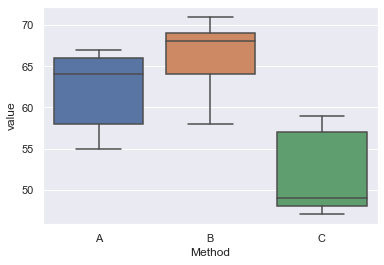

In [54]:
# 绘出箱形图
sns.boxplot(x = "Method",y = "value", data = chemitechcleaned)

<AxesSubplot:xlabel='Method', ylabel='value'>

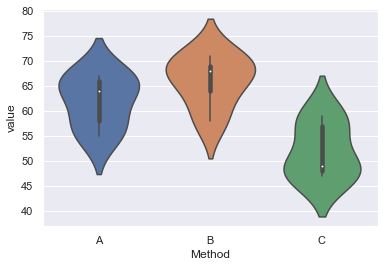

In [55]:
sns.violinplot(x = "Method",y = "value", data = chemitechcleaned)

## 方差分析和完全随机化实验设计
本节中，将说明 对于一个完全随机化实验设计 如何应用方差分析来检验$k$个总体均值是否相等的问题 被检验的假设的一般形式为:
- $H_0: \mu_1 = \mu_2 = ... = \mu_k$
- $H_\alpha$: k 个总体的均值不全相等

式中，$\mu_j$ 代表的是第 $j$ 个总体的均值

假定从$k$个总体或处理中的每一个抽取一个容量为$n_j$的简单随机样本 对于得到的样本数据 令$x_ij$代表的第$j$个处理的第$i$个观测值  $n-j$代表第$j$个处理的观测值个数 $\bar x_j$代表的$j$个处理的样本均值  $s_j^2$代表第$j$个处理的样本方差  $s_j$代表第$j$个处理的样本标准差

第$j$个处理的样本均值与样本方差的计算公式：
$$\bar x_j = \frac{\sum\limits_{n=1}^{n_j} x_{ij}}{n_j}$$

总样本均值 记为$\bar{\bar x}$ 等于所有观测值之和除以观测值的总个数

$$\bar{\bar x} = \frac{\sum_{j=1}^{k} \sum_{n=1}^{n_j} x_{ij}}{n_T}$$

式中 $n_T=n_1+n_2+ ... + n_k$

若每个样本的容量是相等的 都为$n$ 则$n_T=kn$ 在这种情形下 简化为

$$\bar {\bar x} = \frac{\sum\limits_{j=1}^k \bar x_j}{k}$$

在 Chemitech 的例子中，因为每个样本的样本量都是 5，因此我们可以直接计算总体均值 $\mu$：

In [58]:
chemitech.mean().mean()

60.000

## 总体方差的处理间估计

总体方差的处理间估计原理：原假设为真，在这种情形下，每个样本都来自同一个总体，并$\bar x$只有一个抽样分布

$\sigma^2$的这个估计量为均方处理（mean square due to treatments, MSTR)
$$MSTR = \frac{\sum\limits_{j=1}^{k} n_j (\bar x_j - \bar {\bar x})^2}{k-1}$$

处理平方和：（sum of squares due to treatments, SSTR)
$$SSTR = \sum\limits_{j=1}^k n_j(\bar x_j - \bar {\bar x})^2$$

上述试验中
$$SSTR = 5 \times (62-60)^2 + 5 \times (66-60)^2 + 5 \times (52-60)^2 = 520$$
$$MSTR = \frac{SSTR}{K-1} = \frac{520}{2} = 260$$

## 总体方差的处理间估计

总体方差的处理间估计原理：每个样本的内部变异也会对我们得到的方差分析的结论产生影响。

当我们从每个总体中抽取一个随机样本时，每个样本方差都给出了 $\sigma^2$ 的的一个无偏估计。

将 $\sigma^2$ 的个别估计组合或合并成一个总的估计，用这种方法得到的 $\sigma^2$ 的估计称为 $\sigma^2$ 的合并估计或处理内估计

误差平方和 (sum of squares due to error)

$$SSE = \sum\limits_{j=1}^k (n_j - 1) s_j^2$$

均方误差（mean square due to error)
$$MSE = \frac{\sum\limits_{j=1}^k (n_j - 1) s_j^2}{n_T-k}$$

上述试验中
$$SSE = (5-1)\times 27.5 + (5-1) \times 26.5 + (5-1)\times 31 = 340$$
$$MSE = \frac{340}{15-3} = 28.33$$

## 方差估计量的比较：$F$检验
k个总体均值相等的检验
$H_0: \mu_1 = \mu_2 = ... = \mu_k$

检验统计量：

$$F = \frac{MSTR}{MSE}$$

式中，$F_{\alpha}$ 是分子自由度为 $k-1$, 分母自由度为 $n_T-k$ 时，$F$ 分布的上侧曲线下方面积为 $\alpha$ 的 $F$ 值

拒绝法则：
- p-值法：如果 $p- \le \alpha$，则拒绝 $H_0$
- 临界值法：如果 $F \ge F_alpha$，则拒绝 $H_0$

计算可得，案例的 $F = \frac{260}{28.33} = 9.18$，对应的 $p- = 0.004$ 小于 $\alpha = 0.05$，因此我们可以拒绝零假设，认为三个组的总体均值是不相等的。

下面我们用 Python 验证一下计算结果：

In [59]:
f_oneway(chemitech['Method A'], chemitech['Method B'], chemitech['Method C'])

F_onewayResult(statistic=9.176470588235295, pvalue=0.0038184120755124806)

直观地理解，效应（MSTR）是不同小提琴之间的高度差，误差（MSE）是每个小提琴的高度。
- 小提琴之间的高度差，即效应的大小，叫作组间差异。
- 各个小提琴的高度，即误差的大小，叫作组内差异。

<AxesSubplot:xlabel='Method', ylabel='value'>

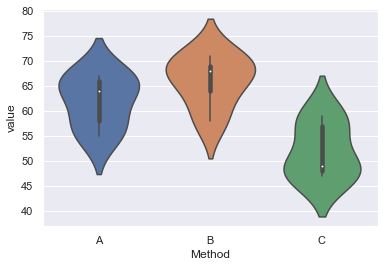

In [72]:
sns.violinplot(x = "Method",y = "value", data = chemitechcleaned)

由于 `scipy` 提供的统计信息有限，如果你想要了解更多的统计量，可以使用 `statsmodels` 的方差分析函数，[参考](https://www.pythonfordatascience.org/anova-python/)

`statsmodels` 公式的 API 使用 [Patsy](https://patsy.readthedocs.io/en/latest/) 来处理传递的公式，伪代码如下：
```python
smf.ols("dependent_variable ~ independent_variable1 + independent_variable2 + independent_variablen", data = df).fit()
```

为了区分定类变量，需要对变量进行处理：`C(independent_variable)`，伪代码如下：

```python
smf.ols("dependent_variable ~ independent_variable1 + C(independent_variable2)", data = df).fit()
```

默认情况下，Patsy 会选择第一个定类变量作为参考变量，但是我们也可以指定其他定类变量作为参考变量，伪代码如下：

```python
smf.ols("dependent_variable ~ independent_variable1 + C(independent_variable2, Treatment(categorical_group))", data = df).fit()
```

其中 `categorical_group` 就是参考变量。

需要注意的是，`anova_lm`函数里面的`typ`参数指定平方和的计算方式，具体解释在[这里](https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html)

如果`typ`参数为 3，方差分析时需要做一些[调整](https://www.pythonfordatascience.org/anova-sum-of-squares-statsmodels-python/).

In [61]:
model = smf.ols('value ~ C(Method)', data=chemitechcleaned).fit()

# 是否满足假设检验的前提

如果想要确保数据分析结果是可信的，在进行分析之前，我们需要先检查数据集是否满足假设检验的前提。[详见](https://www.pythonfordatascience.org/parametric-assumptions-python/)

## 独立性

在进行研究设计的时候，就应该提前考虑独立性这个问题。

这意味着数据集的每一个组都是互相独立的：

- 每个统计样本只能属于某一个组，不能同时属于两个组
- 统计样本没有被重复计量

在这个案例里面，数据是满足独立性的。

## 正态分布

常用的正态分布检验方法是 Shapiro-Wilk 方法。我们可以直接用这个函数来检验：

In [62]:
shapiro(model.resid)

ShapiroResult(statistic=0.9175854921340942, pvalue=0.1769532859325409)

p-value > 0.05，意味着数据是正态分布的。

另一种检验方法是视觉检验（我刚开始看到这里也觉得很惊奇）。

针对样本量非常大的情况，Shapiro-Wilk 方法往往会拒绝零假设（想想之前是不是也碰到过对样本量敏感的情况？）

因为随着样本量的增加，特别微小的差异也会被样本数量放大。

其中一种视觉检验方法就是结合正态概率图和 $R^2$ 来评估观测值和理论分布（在这里是正态分布）的相关程度。

[相关资料](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3676.htm)

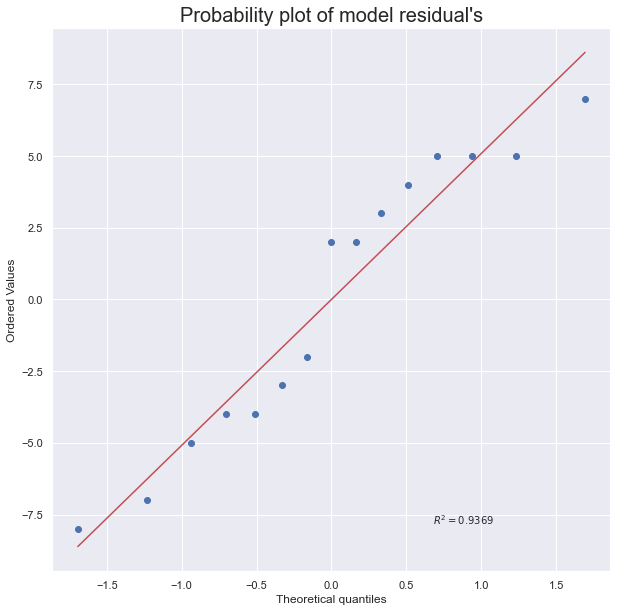

In [63]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

当前的案例就是一个比较特殊的情况：统计量的结果表明数据集是服从正态分布的，但是正态分布图的结果却表示数据集并不服从正态分布。

由于我们的数据量非常小，因此我们采信统计量的结果。

## 方差齐性检验

方差齐性分析通过分析方差来验证是否满足假设检验的前提

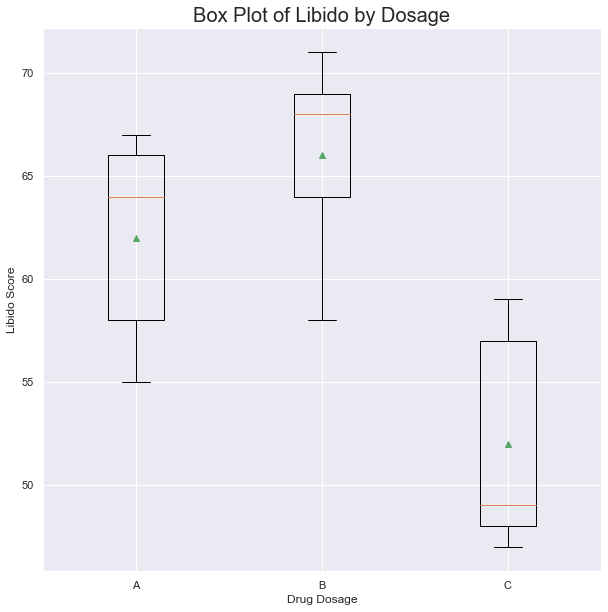

In [160]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Libido by Dosage", fontsize= 20)
ax.set

data = [chemitechcleaned['value'][chemitechcleaned['Method'] == 'A'],
        chemitechcleaned['value'][chemitechcleaned['Method'] == 'B'],
        chemitechcleaned['value'][chemitechcleaned['Method'] == 'C']]

ax.boxplot(data,
           labels= ['A', 'B', 'C'],
           showmeans= True)

plt.xlabel("Drug Dosage")
plt.ylabel("Libido Score")

plt.show()

In [164]:
# 这里的代码怎么样才能用迭代器进行优化？
stat, p = levene(chemitech['Method A'], chemitech['Method B'], chemitech['Method C'])
print('stat',stat)
print('p',p)
stat, p = bartlett(chemitech['Method A'], chemitech['Method B'], chemitech['Method C'])
print('stat',stat)
print('p',p)

stat 0.029166666666666674
p 0.9713232087188124
stat 0.024476260740378564
p 0.987836450991783


p 值越小，意味着组间方差的差距越大。

In [166]:
# 处理一下数据，后续有用
chemitech = pd.read_csv(DATA/'Chemitech.csv')
chemitech

,Method A,Method B,Method C
0,58,58,48
1,64,69,57
2,55,71,59
3,66,64,47
4,67,68,49


In [175]:
np.var(chemitech, ddof=1)

index     2.142857
value    61.428571
dtype: float64

其中：

- 橙色线：中位数
- 绿色块：组内均值

In [65]:
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Method),520.0,2.0,9.176471,0.003818
Residual,340.0,12.0,NaN,NaN


- Df 是自由度（degrees of freedom）
- Sum Sq 是平方和（sum of squares）
- Mean Sq 是均方误差（meansquares，即 mean-squared deviations 的缩写）
- F value是 F 统计量。

In [66]:
"""
The function below was created specifically for the one-way ANOVA table 
results returned for Type II sum of squares
"""
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [73]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Method),520.0,2.0,260.000000,9.176471,0.003818,0.604651,0.521576
Residual,340.0,12.0,28.333333,NaN,NaN,NaN,NaN


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Method),520.0,2.0,260.000000,9.176471,0.003818,0.604651,0.521576
Residual,340.0,12.0,28.333333,NaN,NaN,NaN,NaN


# 多重比较方法

当我们应用方差分析方法检验 $k$ 个总体均值是否相等时，拒绝原假设只能让我们得出 $k$ 个总体的均值**不全相等**的结论。

使用多重比较方法，可以确定 $k$ 个均值中间**到底哪几个均值**之间存在差异，在成对的总体均值之间进行比较。

## $Fisher$的$LSD$方法

基于检验统计量$\bar x_i - \bar x_j$的$Fisher$的$LSD$方法
- $H_0: \mu_i = \mu_j$，$H_\alpha: \mu_i \neq \mu_j$
- 检验统计量： $\bar x_i - \bar x_j$
- 显著性水平 $\alpha$ 下的拒绝法则
- 如果 $|\bar x_i - \bar x_j| \ge LSD$, 则拒绝 $H_0$

式中：

$$LSD = t_\alpha/2 \sqrt{MSE(\frac{1}{n_i}+\frac{1}{n_j})}$$

应用Fisher的LSD方法的两个总体均值之差的置信区间估计

$\bar x_i - \bar x_j \pm LSD$

其中, $t_{\alpha}$ 是自由度为 $n_T-k$ 时，使 $t$ 分布的上侧面积为 $\alpha/2$ 的 $t$ 值

## [HSD](https://methods.sagepub.com/reference/encyc-of-research-design/n478.xml)

In [68]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(chemitechcleaned['value'], chemitechcleaned['Method'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,4.0,0.482,-4.9814,12.9814,False
A,C,-10.0,0.0292,-18.9814,-1.0186,True
B,C,-14.0,0.0035,-22.9814,-5.0186,True


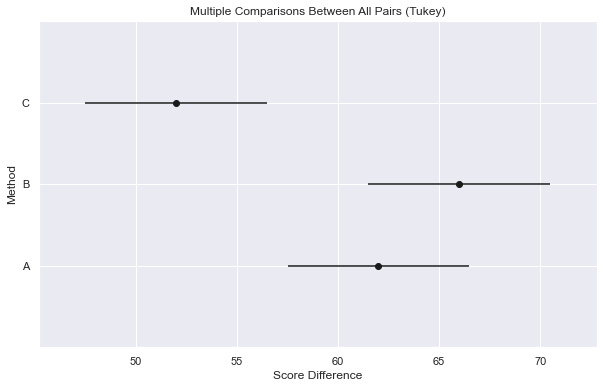

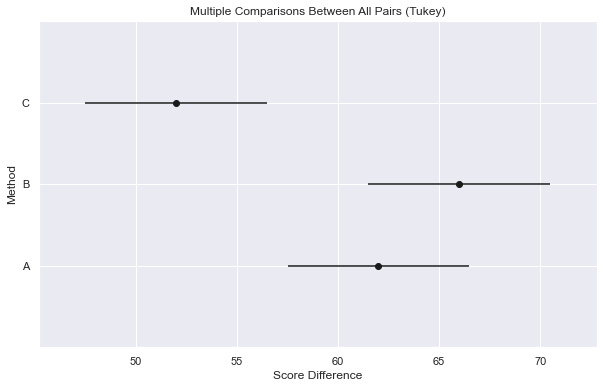

In [69]:
post_hoc_res.plot_simultaneous(ylabel= "Method", xlabel= "Score Difference")

## [Bonferroni](https://methods.sagepub.com/reference/encyc-of-research-design/n33.xml)

In [159]:
comp = mc.MultiComparison(chemitechcleaned['value'], chemitechcleaned['Method'])
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
A,B,-1.2172,0.2582,0.7747,False
A,C,2.9235,0.0192,0.0576,False
B,C,4.1284,0.0033,0.0099,True


## [Šidák](https://methods.sagepub.com/reference/the-sage-dictionary-of-statistics/n166.xml?fromsearch=true)

In [71]:
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "sidak")
tbl

group1,group2,stat,pval,pval_corr,reject
A,B,-1.2172,0.2582,0.5919,False
A,C,2.9235,0.0192,0.0565,False
B,C,4.1284,0.0033,0.0099,True


## 第一类错误概率

我们开始讨论 Fisher 的 LSD 方法的前提是，方差分析为我们提供了拒绝总体均值相等的原假设的统计证据。

在这种情形下，我们说明了如何使用 Fisher 的 LSD 方法来确定，总体均值之间的差异到底出现在哪些均值之间。

在技术上，Fisher 的 LSD 方法被称为保护性或限制性 LSD 检验，因为只有当我们首先找到一个用于方差分析的显著的 F 值时，我们才使用LSD检验。

为了弄清楚在多重比较检验中，这种区别为什么是重要的，我们需要解释一下比较方式的第 I 类错误概率与实验方式的第I类错误概率的区别：

在 Chemitech 公司实验的例子中，我们利用 Fisher 的 LSD 方法做了三个成对的两两比较。

在每一种情形下，我们都使用 $\alpha=0.05$ 的显著性水平。因此，对每个检验，如果原假设为真，则犯第 I 类错误的概率为 $\alpha=0.05$，不犯第I类错误的概率就是 1-0.05=0.95。

在讨论多重比较方法时，我们把这个第 I 类错误的概率 $\alpha=0.05$ 称为**比较方式的第 I 类错误概率**（comparison wise Type I error rate）。

比较方式的第 I 类错误既率表示了与单个两两比较相联系的显著性水平。

现在我们考虑一个略为不同的问题。在进行三次成对的两两比较时，三次检验中至少有一次犯第 I 类错误的概率是多少？

为回答这个问题，我们注意到三次检验都不犯第 I 类错误的概率为 $(1-\alpha)^3={0.95}^3=0.8574$。

因此，至少有一次犯第I类错误的概率为 1-0.8574=0.1426。这样当我们用 Fisher 的 LSD 方法进行三次成对的两两比较时，对应的犯第I类错误概率已经不是 0.05，其实是 0.1426。

我们将这个错误概率称为总的或实验方式的第 I 类错误概率（experiment wise Type I error rate）。为避免混滑，我们将实验方式的第 I 类错误概率记为 $\alpha_{EW}$。

对于总体个数较多的问题，犯实验方式第 I 类错误的概率就会变得比较大，例如对于有5个总体，10个可能成对的两两比较的问题。在比较方式的第I类错误概率为 $\alpha=0.05$ 时，如果我们利用 Fisher 的 LSD 方法检验所有可能成对的两两比较，则犯实验方式第 I 类错误的概率将是 $1-(1-0.05)^{10}=0.40$。

在这种情形下，有实际经验的专业人员将会寻求其他方法，以更好地控制犯实验方式第 I 类错误的概率。

控制总的犯实验方式错误概率的一种方法被称为 Bonferroni 修正方法，该方法在每一次检验中都使用一个较小的比较方式错误概率。例如，如果我们想要检验  $C$ 个成对的两两比较，并希望总的犯实验方式第 I 类错误的最大概率为 $\alpha_{EW}$ ，那么我们只要简单地将犯比较方式错误的概率等于 $\alpha_{EW}/C$ 即可。

在Chemitech公司实验的例子中，如果我们想要使用 Fisher 的 LSD 方法检验所有三个成对的两两比较，并且希望犯实验方式错误的最大概率为 $\alpha_{EW}=0.05$，那么我们只要设比较方式的错误概率为 $\alpha_{EW} = 0.05/3 = 0.017$ 即可。

对于有 5 个总体，10 种可能成对的两两比较的问题，Bonferroni修正方法建议的比较方式错误概率为 $\alpha_{EW} = 0.05/10 = 0.005$。

回忆第 9 章有关假设检验的讨论，对于固定的样本容量，减少犯第 I 类错误的概率将增加犯第 Ⅱ 类错误的概率，而第 Ⅱ 类错误是指当两个总体的均值实际上不相等时，却接受了两个总体均值相等的原假设。

由于犯第 Ⅱ 类错误的风险增加，因此许多有实际经验的专业人员不愿在一个比较低的犯比较方式第 I 类错误的概率下，进行单个
的两两比较检验。

在这种情况下，还有几种其他方法如 Tukey 方法与 Duncan 多重区域检验，也可用于解决这类问题。但是究竞哪种方法是“最优的”，在统计学界存有较大争议。事实上，没有任何一种方法对所有类型的问题都是最优的。

# [复测方差分析](https://www.statology.org/repeated-measures-anova-python/)

在学习复测方差分析之前，让我们来回顾一下配对样本 t 检验：
- 配对样本 t 检验：一个二值定类变量，一个定量变量，且定量变量需要配对（如同一个患者使用药品前/使用药品后的数据）
- 配对样本 t 检验可以处理一个因变量在两个时间点的取值。

如果要检验定类因变量不是二值变量，而有三类或者更多类别，我们该采用什么方法呢？

这个情况，就是复测方差分析发挥作用的时候了。

除了满足独立、正态分布和方差齐次之外，复测方差分析还需要满足**球对称假设**：

> 对于被试者内因素的各个水平组合而言，因变量的协方差矩阵相等。球形检验(Mauchly's test of sphericity) , 适用于重复测量时，检验不同测量之间的差值的方差是否相等，用于三次以及三次以上水平的重复测量(因为两次重复测量根本就没有办法比较差值的方差,只有一个方差)。

下面我们来看看案例数据：

In [133]:
df = pd.DataFrame({'patient': np.repeat([1, 2, 3, 4, 5], 4),
                   'drug': np.tile([1, 2, 3, 4], 5),
                   'response': [30, 28, 16, 34, 14, 18, 10, 22, 24, 20, 
                                18, 30, 38, 34, 20, 44, 26, 28, 14, 30]})

#view first ten rows of data 
df.head()

,patient,drug,response
0,1,1,30
1,1,2,28
2,1,3,16
3,1,4,34
4,2,1,14


In [134]:
from statsmodels.stats.anova import AnovaRM
print(AnovaRM(data=df, depvar='response', subject='patient', within=['drug']).fit())

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
drug 24.7589 3.0000 12.0000 0.0000



In this example, the F test-statistic is 24.7589 and the corresponding p-value is 0.0000. Since this p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in mean response times between the four drugs.

# Type II ANOVA

本段参考《用Python动手学统计学》

### [多因素方差分析估计平方和的三种方法](https://zhuanlan.zhihu.com/p/141091876)

在做多因素方差分析时，有三种方法计算平方和（以模型Y ~ A + B + A:B为例，即先输入A，再输入B，最后输入交互项A:B）：

Type Ⅰ Sums of Squares（Type1, sequential）
序贯型，后输入的因素根据之前输入的因素做调整，与输入顺序有关（A不做调整，B根据A做调整，A:B根据A和B做调整，因此使用Type1要注意模型中各因素的输入顺序）。
Type Ⅱ Sums of Squares（Type2, hierarchical）
分层型，根据同阶水平和低阶水平的因素做调整，与输入顺序无关（A和B同是一阶的，A根据B做调整，B根据A做调整；A:B是二阶的，因而A:B根据A和B做调整）。
Type Ⅲ Sums of Squares（Type3, marginal）
边界型，根据其他所有因素做调整，与输入顺序无关（A根据B和A:B做调整，B根据A和A:B做调整，A:B根据A和B做调整）。


这些分类在参考文献中有详细的介绍。当数据均衡（data is balanced，即各水平的样本量相等），且因素是正交的（factories are orthogonal，即各因素独立，讨论见：[What does orthogonal mean in the context of statistics?](https://stats.stackexchange.com/questions/12128/what-does-orthogonal-mean-in-the-context-of-statistics)），

以上三种方法计算出来的结果相同；其他情况下，就需要按照自己的试验设计和研究目的选择使用了。在不同的统计软件中有不同的实现

下面我们让预测销售额的模型包含湿度、气温、天气（晴或雨）、价格 4 个解释变量。

天气为定类变量，其余为定量变量。即使有多个解释变量，也可以通过正态线性模型完成统一的分析、解读与预测。

In [77]:
# 读入数据
sales = pd.read_csv(DATA/"lm-model.csv")
sales.head()

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy
3,39.7,290,195.5,23.0,rainy
4,24.7,290,214.4,14.5,rainy


在进行数据分析时，第一步永远是可视化。统计、模型化等工作全都要放在后面去做。解释变量有多个，因此这里绘制散点图矩阵

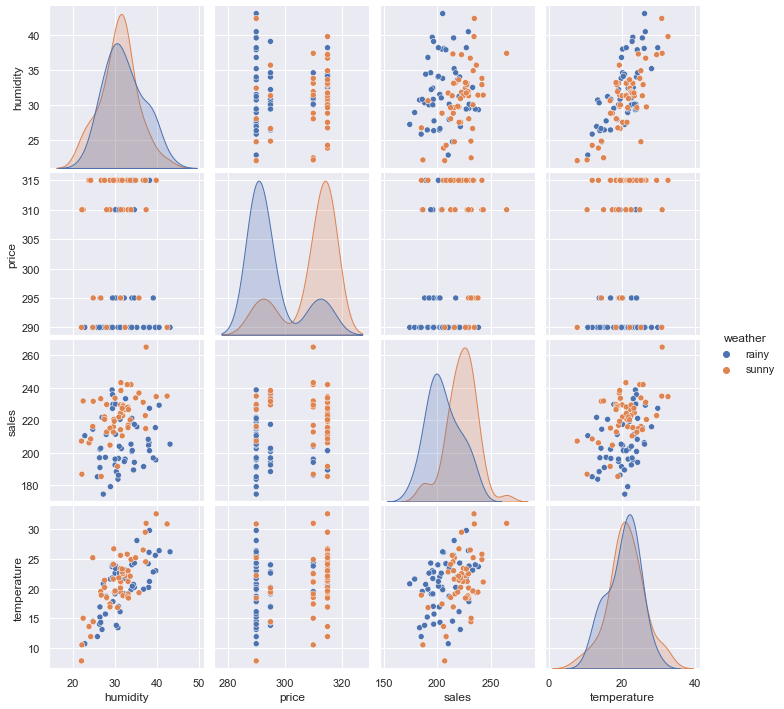

In [78]:
# 数据可视化
sns.pairplot(data = sales, hue = "weather")

矩阵第 3 行的纵轴为销售额。只观察这一行难以判断各因素是否影响销售额。

虽然一部分原因在于数据是虚构的，但其实现实世界的数据也经常会出现这种难以仅根据图形进行判断的情况。

在这个矩阵中，较为明显的是湿度（humidity）和气温（temperature）的关系。气温越高，则湿度越高。

## 错误的分析：建立只有 1 个变量的模型

在设计多解释变量模型之前，我们先来了解一个反例：在模型需要多个解释变量时只选 1 个变量。

假设我们受限于工具只能进行一元回归分析，那么如果强行用这样的工具继续进行分析，最终会得到错误的结果。

只使用价格这 1 个解释变量进行一元回归分析，得到的价格系数为正值。


In [79]:
# 只使用价格这 1 种解释变量进行建模
lm_dame = smf.ols("sales ~ price", sales).fit()
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

In [80]:
# 价格的系数与 0 存在显著性差异
sm.stats.anova_lm(lm_dame, typ=2)

,sum_sq,df,F,PR(>F)
price,1398.392322,1.0,4.970685,0.028064
Residual,27570.133578,98.0,NaN,NaN


根据上面的结果，可以认为价格显著影响了啤酒的销售额，价格越高，销售额就越高。

要提升销售额，只需提高价格即可。最后不妨强行绘制回归直线。这条直线必然向右上倾斜，那么我们就会以为只要提高价格，销售额也就可以得到提升

In [ ]:
# 价格与销售额的关系
sns.lmplot(x = "price", y = "sales", data = sales,
           scatter_kws = {"color": "blue"},
           line_kws    = {"color": "red"})

## 分析解释变量之间的关系

上一节的反例中的问题在于只关注了价格。我们可以通过简单的统计方法得知商店的定价策略。使用 groupby 函数计算各天气下的均值。并使用提琴图展示数据。

In [84]:
# 计算各天气下的均值
sales.groupby("weather").mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


<AxesSubplot:xlabel='price', ylabel='sales'>

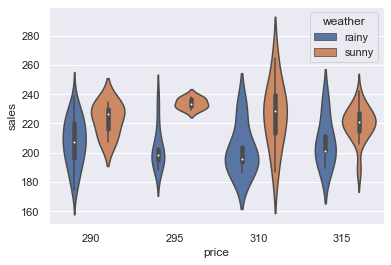

In [85]:
sns.violinplot(x = "price",y = "sales", data = sales, hue = "weather")

可以看到，销售额（sales）在雨天（rainy）时更低。同时，雨天的价格也比较低。

比较自然的理解是“**雨天的销量会下降，所以商店调低了价格**”。如此一来，销售额也就随之降低了。

在相同天气下，价格对销售额的影响又有多大呢？我们可以绘制出图形来看一下（图 5-12）。

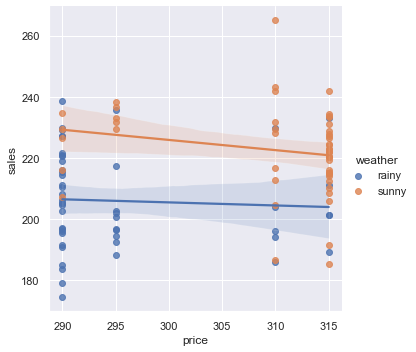

In [86]:
# 不同天气中销售额—价格回归直线
sns.lmplot(x = "price", y = "sales", data = sales, hue="weather")

从图中可以看出，晴天的销售额更高；相同天气下价格越高，销售额越低。这个结果与上一节相反。我们本来希望数据中的解释变量之间互不相关，但现实中不可能为了简化分析而命令商店随机定价，所以在分析这类数据时不能太过草率。

过去人们有时会先按天气区分数据，再用回归分析分别考察晴天和雨天时价格和销售额的关系。

但是，这种方法需要进行两次参数估计，会导致多重假设检验问题。要探明各因素对响应变量的影响，必须一次性完成对多解释变量模型的估计。

在 `sns.lmplot` 中，晴天和雨天的斜率不同。而我们的分析需要以二者斜率相同为前提。

## 多解释变量的模型

下面估计有 4 个解释变量的模型。在定义多解释变量的模型时，解释变量之间用加号（+）连接。

In [87]:
# 估计多解释变量的模型
lm_sales = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    data=sales).fit()
# 估计的结果
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

### 错误的分析：使用普通方差分析

我们使用检验来判断解释变量是否显著影响响应变量。在本节的例子中，如果使用普通的方差分析，就会出现问题。

首先进行普通的方差分析（会出现警告信息）。
- typ = 1 就表示进行普通的方差分析，这种方差分析也叫 Type I ANOVA。
- round(3) 表示令输出保留 3 位小数。

In [89]:
# 普通方差分析
sm.stats.anova_lm(lm_sales, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
humidity,1.0,1779.601,1779.601,9.805,0.002
temperature,1.0,2076.845,2076.845,11.443,0.001
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


从上述结果可知，所有解释变量都是必需的，然而这个检验结果是错误的。

在Type I ANOVA 中，如果**改变解释变量的顺序，检验结果也会不一样**。为了验证这一点，我们保持变量个数和种类不变，只改变变量顺序再试一次。

In [91]:
# 改变解释变量的顺序
lm_sales_2 = smf.ols(
    "sales ~ weather + temperature + humidity + price",
    data=sales).fit()
# 检验结果
sm.stats.anova_lm(lm_sales_2, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
temperature,1.0,3814.779,3814.779,21.018,0.000
humidity,1.0,41.667,41.667,0.230,0.633
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


这里交换了气温和湿度的位置。
- 模型 1：sales ~ weather + humidity + temperature + price
- 模型 2：sales ~ weather + temperature + humidity + price

变量只改变了位置，估计的参数还是不变的，但检验结果却变了。第 2 个模型中湿度的 $p$ 值约为 0.6，被认为不存在显著影响。

不使用方差分析，而对回归系数进行 $t$ 检验，就能避免这个问题。下面只打印系数及其检验结果。

In [92]:
# 模型 1 的回归系数的 t 检验
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [93]:
# 模型 2 的回归系数的 t 检验
lm_sales_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


在两次检验中，湿度的回归系数的 $p$ 值都是 0.578。

由此可知，在回归系数的 $t$ 检验中，解释变量的顺序不会引起什么问题。

然而，本例中的天气只有晴、雨两个水平，如果在进行 $t$ 检验时加上阴天，就会出现多重假设检验问题。

## Type II ANOVA

Type II ANOVA 是方差分析的一种，它的结果不会因解释变量顺序的不同而不同。虽然依照严密的实验方案得到的数据受 Type I ANOVA 中问题的影响不大，但这次的例子更适合使用 Type II ANOVA。

这里先介绍一下对多解释变量的模型应用 Type I ANOVA 的计算方法。考察变量为如下顺序的模型：

`sales ~ 1 + weather + humidity + temperature + price`

开头的 1 代表截距。我们逐个增加变量。最开始是无解释变量的空模型，求它的残差平方和。

In [95]:
# 空模型的残差平方和
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
resid_sq_null

28968.526

In [96]:
# 天气模型的残差平方和
mod_1 = smf.ols("sales ~ weather", sales).fit()
resid_sq_1 = np.sum(mod_1.resid ** 2)
resid_sq_1

21917.565

In [97]:
# 残差平方和的差
resid_sq_null - resid_sq_1

7050.961

In [98]:
sm.stats.anova_lm(mod_1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,31.527,0.0
Residual,98.0,21917.565,223.649,NaN,NaN


In [99]:
# "天气 + 湿度" 模型的残差平方和
mod_2 = smf.ols(
    "sales ~ weather + humidity", sales).fit()
resid_sq_2 = np.sum(mod_2.resid ** 2)
resid_sq_2

20137.964

In [100]:
# 残差平方和的差
resid_sq_1 - resid_sq_2

1779.601

In [101]:
sm.stats.anova_lm(mod_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,33.963,0.000
humidity,1.0,1779.601,1779.601,8.572,0.004
Residual,97.0,20137.964,207.608,NaN,NaN


天气变化对应的组间偏差平方和就是在空模型中加入天气变量后减少的残差平方和。

下面进一步在模型中加入湿度变量，并求残差平方和。

In [102]:
# "天气 + 气温" 模型的残差平方和
mod_2_2 = smf.ols(
    "sales ~ weather + temperature", sales).fit()
resid_sq_2_2 = np.sum(mod_2_2.resid ** 2)
resid_sq_2_2

18102.786

In [103]:
# "天气 + 气温 + 湿度" 模型的残差平方和
mod_3_2 = smf.ols(
    "sales ~ weather + temperature + humidity",
    sales).fit()
resid_sq_3_2 = np.sum(mod_3_2.resid ** 2)
resid_sq_3_2

18061.119

In [104]:
resid_sq_2_2 - resid_sq_3_2

41.667

In [105]:
sm.stats.anova_lm(mod_3_2).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,37.478,0.000
temperature,1.0,3814.779,3814.779,20.277,0.000
humidity,1.0,41.667,41.667,0.221,0.639
Residual,96.0,18061.119,188.137,NaN,NaN


- 在多解释变量模型的方差分析中，变量个数增加时所减少的残差平方和决定了变量的效应大小（方差分析表中的 sum_sq）。
- 在使用这种方法的情况下，sum_sq 的值会因解释变量的添加顺序不同而不同，对于解释变量是否存在显著性影响的判断也不同。
- 这种检验方法叫作 Type I ANOVA。对多解释变量模型进行 Type I ANOVA 可能会导致错误的结论。

Type I ANOVA 按如下顺序对比残差平方和。先建立如下模型。
0. 模型 0：销售额~ 　 　 　 　　　　　　　　+ 残差平方和
1. 模型 1：销售额~天气 　 　 　 　　　　　　+ 残差平方和
2. 模型 2：销售额~天气 + 湿度　 　 　 　　　+ 残差平方和
3. 模型 3：销售额~天气 + 湿度 + 气温　　 　 + 残差平方和
4. 模型 4：销售额~天气 + 湿度 + 气温 + 价格 + 残差平方和

再分别对比模型 0 与模型 1 的残差平方和、模型 1 与模型 2 的残差平方和……最后检验各解释变量的必要性。

Type II ANOVA 按如下顺序对比残差平方和。先建立如下模型。
0. 模型 0：销售额~天气 + 湿度 + 气温 + 价格 + 残差平方和
1. 模型 1：销售额~　　　 湿度 + 气温 + 价格 + 残差平方和
2. 模型 2：销售额~天气　　 　 + 气温 + 价格 + 残差平方和
3. 模型 3：销售额~天气 + 湿度 　 　　+ 价格 + 残差平方和
4. 模型 4：销售额~天气 + 湿度 + 气温 　 　　+ 残差平方和

再分别对比每个模型与模型 0 的残差平方和。

Type II ANOVA 根据解释变量减少时所增加的残差平方和量化解释变量的效应。

即使解释变量的顺序不同，这种方法的结果也不会改变。通过这种方法得到的组间偏差平方和就叫作调整平方和。

### 实现：Type II ANOVA

In [107]:
# 包含所有解释变量的模型的残差平方和
mod_full = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    sales).fit()
resid_sq_full = np.sum(mod_full.resid ** 2)
resid_sq_full

17242.717

In [108]:
# 不含湿度的模型的残差平方和
mod_non_humi = smf.ols(
    "sales ~ weather + temperature + price", 
    sales).fit()
resid_sq_non_humi = np.sum(mod_non_humi.resid ** 2)
resid_sq_non_humi

17299.142

In [109]:
# 调整平方和
resid_sq_non_humi - resid_sq_full

56.425

In [110]:
# Type II ANOVA
sm.stats.anova_lm(mod_full, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,5845.878,1.0,32.208,0.000
humidity,56.425,1.0,0.311,0.578
temperature,2378.017,1.0,13.102,0.000
price,818.402,1.0,4.509,0.036
Residual,17242.717,95.0,NaN,NaN


$p$ 值为 0.578，此时认为湿度对销售额没有显著影响。

当解释变量只有一个时，Type I ANOVA 与 Type II ANOVA 的结果相等。为了便于在多种情况下解读检验结果，笔者推荐使用 Type II ANOVA。

包中还提供了直接对比两个模型的函数。

In [112]:
# 对比这两个模型
mod_full.compare_f_test(mod_non_humi)
# 输出的值分别为 F 比、p 值、两个模型自由度的差。

(0.311, 0.578, 1.000)

通过 Type II ANOVA 对湿度影响进行检验的结果可以解读为对“在模型中已经有了其他变量的情况下，加入湿度因素是否还能影响销售额”的调查。

湿度与气温的相关度很强，因此可能存在这种情况：如果模型中包含了气温，就无法认为湿度会对销售额产生显著影响。

### 变量选择与模型选择

下面使用 Type II ANOVA 进行变量选择。已知湿度是非必需的，所以我们继续对不含湿度的模型 mod_non_humi 进行 Type II ANOVA。

In [113]:
sm.stats.anova_lm(mod_non_humi, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,6354.966,1.0,35.266,0.000
temperature,4254.736,1.0,23.611,0.000
price,803.644,1.0,4.460,0.037
Residual,17299.142,96.0,NaN,NaN


所有变量都是必要的。至此，变量选择结束。

系数等结果的解读应该使用变量选择后的模型进行，不应该将通过错误的变量组合进行模型化的结果用于预测或解读。

例如，使用只含价格的模型的系数来解读本节的模型，就会得到错误的结论。本节的模型的系数如下。

In [114]:
mod_non_humi.params

Intercept           273.301800
weather[T.sunny]     20.393871
temperature           1.417860
price                -0.326001
dtype: float64

`weather[T.sunny]` 的含义是**晴天比雨天的销售额多约 20**。

我们可以像前面章节介绍的那样使用这些系数预测销售额。

### 使用 AIC 进行变量选择

如果使用 AIC 进行变量选择，就没必要像方差分析那样更换计算方法，直接建模并计算 AIC 即可。

下面比较包含所有变量的模型 mod_full 与不含湿度的模型 mod_non_humi 的AIC。

In [115]:
print("包含所有变量的模型：", mod_full.aic.round(3))
print("不含湿度的模型　　：", mod_non_humi.aic.round(3))

包含所有变量的模型： 808.785
不含湿度的模型　　： 807.112


不含湿度的模型的 AIC 更小，所以湿度不应该包含在销售额预测模型中。

原则上应该对比所有变量组合的 AIC，限于篇幅，此处不再详细介绍。

使用 AIC 进行变量选择的过程是比较固定的。它和系数的 $t$ 检验不同，多水平的变量不会导致多重假设检验问题，所得模型的含义永远是“对未知数据的预测误差最小的变量组合”。

AIC 也没有检验的非对称性问题。AIC 的便利性让它在今天的数据分析中扮演着重要的角色。不过，与不能过度信任 $p$ 值类似，我们也不能过度信任 AIC，还应该从系数的含义、变量选择的结果、残差等多个方面综合评估模型。

## 多重共线性

在解释变量之间相关性很强时出现的问题就是多重共线性。在这次的模型中，气温与湿度就是相关的。在解读类似的模型时需要注意到这一点。

多重共线性问题最简单的解决方案就是去掉强相关变量中的一个。多重共线性会对系数的解读造成干扰，我们应该先进行变量选择再解读结果。

在变量选择的过程中有时会使用检验，但如果变量之间强相关（如相关系数接近1），检验所得的 $p$ 值也会受到干扰。

例如，有两个解释变量，分别为食指的长度和中指的长度，这两个变量的相关系数就可能接近 1，此时可以（根据数据的相关背景知识）提前去掉一个变量再进行模型化。使用 Ridge 回归等能够在一定程度上避免这类问题。

除了推断统计的前提之外，在进行线性回归分析之前，还需要对变量的共线性进行检测。常用的共线性检测方法如下：
- 两个定量变量的共线性检测：皮尔逊相关系数、方差膨胀因子 Variance Inflation Factor (VIF)
- 多个变量的共线性检测：条件数 Condition Number

### 方差膨胀因子 (VIF)

下面我们以 VIF 为例子，一般我们会认为 VIF >= 10 的变量是共线的。可以直接使用 `statsmodels` 查看变量之间[共线性问题](https://www.pythonfordatascience.org/linear-regression-python/#assumption_check)。

注：忽略 Intercept 行结果

In [131]:
x = patsy.dmatrix("humidity + temperature", data = sales)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
vif["Features"] = x.design_info.term_names

vif

,VIF Factor,Features
0,50.121829,Intercept
1,2.155839,humidity
2,2.155839,temperature


### 条件数 Condition Number

除了条件数之外，计算共线性结果的时候，还需要计算特征值。

由于 StatsModels 不提供设计矩阵，因此我们需要使用 numpy 重新创建。

推荐使用和 StatsModels 兼容性比较好的 Pasty 创建设计矩阵。

In [141]:
df = sm.datasets.webuse('auto')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   make          74 non-null     object  
 1   price         74 non-null     int16   
 2   mpg           74 non-null     int16   
 3   rep78         69 non-null     float64 
 4   headroom      74 non-null     float32 
 5   trunk         74 non-null     int16   
 6   weight        74 non-null     int16   
 7   length        74 non-null     int16   
 8   turn          74 non-null     int16   
 9   displacement  74 non-null     int16   
 10  gear_ratio    74 non-null     float32 
 11  foreign       74 non-null     category
dtypes: category(1), float32(2), float64(1), int16(7), object(1)
memory usage: 3.5+ KB


In [150]:
# Note that the order of the columns are the same as the regression formula
x = np.asarray(patsy.dmatrix("weight + C(foreign)", data = df))
# Getting the singular values from SVD

_, sing_as, _ = np.linalg.svd(x)

# Calculating the condiction index
condition_index = []
for n in sing_as:
    ci = sing_as.max() / n
    condition_index.append(ci)

condition_index


[1.000, 5887.960, 18094.091]

接下来获取设计矩阵的奇异值，如果你暂时不了解奇异值和设计矩阵，没关系，先放一放。

下一步，我们会计算条件数，设计矩阵的条件值就是最大的条件数。

In [151]:
eigen_vals = (sing_as * sing_as).round(3)

pd.DataFrame(np.c_[eigen_vals, condition_index],
             columns = ["Eigenvalues", "Condition Index"]).round(1)

,Eigenvalues,Condition Index
0,718762273.1,1.0
1,20.7,5888.0
2,2.2,18094.1


条件值是判定共线性的指标之一，一般认为 0-15 无共线性，15-30 中等共线性，大于 30 部分自变量之间存在共线性

特征值小意味着相关关系强。但是我们不能直接使用特征值作为判断标准，因为至今没有一个阈值判定特征值为“小”。

为了更好地查看变量之间的共线性，通常我们会使用 z 分数来做标准化处理：

In [ ]:
df["weightZ"] = (df["weight"] - df["weight"].mean()) / df["weight"].std()

# Getting the design matrix
xz = np.asarray(patsy.dmatrix("weightZ + C(foreign)", data = df))


# Getting the singular values from SVD
_, sing_as, _ = np.linalg.svd(xz)


# Calculating the condiction index
condition_index = []

for n in sing_as:
    ci = sing_as.max() / n
    condition_index.append(ci)


# The singular values squared are the eigenvalues
eigen_vals = (sing_as * sing_as).round(3)

pd.DataFrame(np.c_[eigen_vals, condition_index],
            columns = ["Eigenvalues", "Condition Index"]).round(1)

经过标准化处理之后的条件值都 < 10，处理好了共线性和估计稳定性的问题。

# [多因素方差分析](https://www.pythonfordatascience.org/factorial-anova-python/)

在前面我们讲过简单的单因素方差分析，这一篇我们讲讲双因素方差分析以及多因素方差分析，双因素方差分析是最简单的多因素方差分析。

单因素分析就是只考虑一个因素会对要比较的均值产生影响，而多因素分析是有多个因素会对均值产生影响。

需要注意的是一个因素可能会有不同的水平值，即不同的取值。比如要判断某一款药对某种病症有没有效果，服用不同的剂量效果应该是不一样的，虽然因素都是服药这一个因素，但是不同的药剂量代表不同的水平。

双因素（多因素）方差分析又可以分为两种，一种是有交互作用的，一种是没有交互作用的。啥意思呢？什么是交互作用呢？

比如我们大家所熟知的，牛奶和药是不可以一起吃的，如果单独喝牛奶有助于身体蛋白质的补充，如果单独吃药可以有助于治疗病症，但是牛奶和药同时吃就会把两者的作用抵消掉。这种两者之间的相互作用就可以理解成是交互作用，当然了，有的时候交互是正向呢，有的时候是负向的。

## 双因素方差分析

In [176]:
df = pd.DataFrame({'water': np.repeat(['daily', 'weekly'], 15),
                   'sun': np.tile(np.repeat(['low', 'med', 'high'], 5), 2),
                   'height': [6, 6, 6, 5, 6, 5, 5, 6, 4, 5,
                              6, 6, 7, 8, 7, 3, 4, 4, 4, 5,
                              4, 4, 4, 4, 4, 5, 6, 6, 7, 8]})
df.head()

,water,sun,height
0,daily,low,6
1,daily,low,6
2,daily,low,6
3,daily,low,5
4,daily,low,6


In [177]:
#perform two-way ANOVA
model = ols('height ~ C(water) + C(sun) + C(water):C(sun)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(water),8.533333,1.0,16.0000,0.000527
C(sun),24.866667,2.0,23.3125,0.000002
C(water):C(sun),2.466667,2.0,2.3125,0.120667
Residual,12.800000,24.0,NaN,NaN


我们可以看到结果表中，每个因子对应的 p 值：

water: p-value = .000527
sun: p-value = .0000002
water*sun: p-value = .120667

由于 water 和 sun 的 p 值都小于 0.05，这意味着这两个因子对植物高度的影响都是统计显著的。

又由于交互作用的 p 值 = 0.12 大于 0.05，因此我们可以肯定 water 和 sun 之间的交互作用是统计不显著的。

## 多因素方差分析

实际上，双因素方差分析只是多因素方差分析的特例，现在我们来看一个多因素方差分析的案例：[N-WAY ANOVA](https://www.pythonfordatascience.org/factorial-anova-python/)

由于多因素方差分析至少会有两个以上的变量，因此除了一个定性因变量之外，其他自变量不需要都是定类变量，只需要确保有一个变量是定性变量就可以了，其他变量可以是定量变量。

如果存在两个以上的定量自变量，那就是协方差分析，我们之后会单独讲解协方差分析的相关内容。

三因素方差分析的背景是这样的：

有一个农民想要检验不同组合的化肥、不同用水量和不同日照条件，对作物产量的影响。

我们在数据处理的时候，已经把定量变量进行装箱处理，转化为定类变量。

In [180]:
manufac = sm.datasets.webuse('manuf')
rp.summary_cat(manufac[["temperature", "chemical", "method"]])

,Variable,Outcome,Count,Percent
0,temperature,low,12,33.33
1,,medium,12,33.33
2,,high,12,33.33
3,chemical,A,18,50.00
4,,B,18,50.00
5,method,stir,18,50.00
6,,fold,18,50.00


In [181]:
rp.summary_cont(manufac["yield"])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,yield,36.0,7.5833,3.2371,0.5395,6.4881,8.6786


我们可以看到，数据集有三个定类变量`temperature`, `chemical` 和 `method`，以及一个因变量 `yield`。

`statsmodels`的方差分析的文档[见](https://www.statsmodels.org/stable/anova.html)，由于第三类的平方和是 SP SS、SAS、Stata 等工具默认使用的平方和计算公式，在计算第三类平方和的时候我们需要手动指定组别。

In [182]:
manufac["Yield"] = manufac["yield"]

model = ols("Yield ~ C(temperature, Sum) + C(chemical, Sum) + C(method, Sum) + C(temperature, Sum)*C(chemical, Sum)*C(method, Sum)", data=manufac).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,2070.25,1.0,299.313253,4.675019e-15
"C(temperature, Sum)",30.50,2.0,2.204819,1.321133e-01
"C(chemical, Sum)",12.25,1.0,1.771084,1.957540e-01
"C(method, Sum)",42.25,1.0,6.108434,2.093730e-02
"C(temperature, Sum):C(chemical, Sum)",24.50,2.0,1.771084,1.916714e-01
"C(temperature, Sum):C(method, Sum)",87.50,2.0,6.325301,6.216723e-03
"C(chemical, Sum):C(method, Sum)",0.25,1.0,0.036145,8.508161e-01
"C(temperature, Sum):C(chemical, Sum):C(method, Sum)",3.50,2.0,0.253012,7.785036e-01
Residual,166.00,24.0,NaN,NaN


通过 `C(temperature, Sum):C(chemical, Sum):C(method, Sum)` 的结果可知，三因素方差分析的结果是统计不显著的。

因此，我们可以大胆放心地筛选掉这一行，仅进行双因素方差分析：

In [183]:
model = ols("Yield ~ C(temperature, Sum) + C(chemical, Sum) + C(method, Sum) + C(temperature, Sum):C(chemical, Sum) + C(temperature, Sum):C(method, Sum) + C(chemical, Sum):C(method, Sum)", data=manufac).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,2070.25,1.0,317.560472,4.292571e-16
"C(temperature, Sum)",30.50,2.0,2.339233,1.163633e-01
"C(chemical, Sum)",12.25,1.0,1.879056,1.821599e-01
"C(method, Sum)",42.25,1.0,6.480826,1.717637e-02
"C(temperature, Sum):C(chemical, Sum)",24.50,2.0,1.879056,1.728955e-01
"C(temperature, Sum):C(method, Sum)",87.50,2.0,6.710914,4.467613e-03
"C(chemical, Sum):C(method, Sum)",0.25,1.0,0.038348,8.462683e-01
Residual,169.50,26.0,NaN,NaN



通过双因素方差分析`C(temperature, Sum):C(method, Sum)`的结果可知，温度和方法之间的交互作用是统计显著性的。

因此我们移除其他组别，单独对这一组进行方差分析：

In [184]:
model = ols("Yield ~ C(temperature, Sum) + C(chemical, Sum) + C(method, Sum) + C(temperature, Sum):C(method, Sum)", data=manufac).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,2070.25,1.0,309.072072,5.239664e-17
"C(temperature, Sum)",30.50,2.0,2.276705,1.206672e-01
"C(chemical, Sum)",12.25,1.0,1.828829,1.867181e-01
"C(method, Sum)",42.25,1.0,6.307593,1.784464e-02
"C(temperature, Sum):C(method, Sum)",87.50,2.0,6.531532,4.552060e-03
Residual,194.25,29.0,NaN,NaN


由于第三类方差计算方式的特殊性质，当我们移除了其他统计不显著的变量进行方差分析，不会影响组内平方和。

改变的只有 F 统计量、对应的 p 值。

结论：
A study was designed to determine the optimal operating conditions to maximize yield. The study assessed temperature settings, chemical supply companies, and two mixing methods. The overall interaction between the three factors was statistically non-significant, F(2, 24.0)= 0.2530, p-value= 0.7786. After looking at the reduced model which included all possible 2-factor interactions, the only significant interaction was between temperature and method. The non-signifance interactions were removed and the final model showed that temperature and method have a statistically significant interaction effect on yield, F(2, 29)=6.5315, p-value= 0.0045.


In [185]:
interaction_groups = "Temp_" + manufac.temperature.astype(str) + " & " + "Method_" + manufac.method.astype(str)

comp = mc.MultiComparison(manufac["Yield"], interaction_groups)
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Temp_high & Method_fold,Temp_high & Method_stir,-5.5,0.0121,-10.1072,-0.8928,True
Temp_high & Method_fold,Temp_low & Method_fold,-6.0,0.0052,-10.6072,-1.3928,True
Temp_high & Method_fold,Temp_low & Method_stir,-4.0,0.1184,-8.6072,0.6072,False
Temp_high & Method_fold,Temp_medium & Method_fold,-2.5,0.5733,-7.1072,2.1072,False
Temp_high & Method_fold,Temp_medium & Method_stir,-5.5,0.0121,-10.1072,-0.8928,True
Temp_high & Method_stir,Temp_low & Method_fold,-0.5,0.9994,-5.1072,4.1072,False
Temp_high & Method_stir,Temp_low & Method_stir,1.5,0.9175,-3.1072,6.1072,False
Temp_high & Method_stir,Temp_medium & Method_fold,3.0,0.3764,-1.6072,7.6072,False
Temp_high & Method_stir,Temp_medium & Method_stir,0.0,1.0,-4.6072,4.6072,False
Temp_low & Method_fold,Temp_low & Method_stir,2.0,0.7717,-2.6072,6.6072,False
